In [2]:
import tweepy as tw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
import string
import config
import csv 
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from pathlib import Path
import time 
import shutil

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amirzar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
class Tweet_analysis() :
    """
    This is a class which contains two phases :
    cathcing the data from twitter and analysing the tweets
    Input   : The hastag we want to analyse and the limit of tweets to extract 
    output  : Three graphs ( most frequent words, most frequent mentions and most frequent hashtags )
    """


    def __init__(self , hashtag,limit):
        self.hashtag = hashtag
        self.limit = limit
        path = Path.cwd() / f'{self.hashtag}_{self.limit}Tweets_{time.strftime("%Y-%m-%d|%H:%M:%S")}'
        path.mkdir()  
        self.path = f'./{self.hashtag}_{self.limit}Tweets_{time.strftime("%Y-%m-%d|%H:%M:%S")}'
         
    def tweet_catchers(self):
        """ 
        This function creates a csv file with this header 
        ["Username", "Text", "language",
        retweet_count", "Time", "location"]
        and fill it with most recent tweets containing a specific Hashtag(#)
        """

        # First we will proceed to authorize ourselves with tweepys OAuthHandler.
        # NOTICE: For security we put the api in a separate file and put it in the .gitignore
        auth = tw.OAuthHandler(config.consumer_key, config.consumer_secret)
        auth.set_access_token(config.access_key, config.access_secret)


        # We will now pass these authorization details to tweepy
        api = tw.API(auth, wait_on_rate_limit=True)


        # In the Next step we Create The out Csv file and add the headers to it:
        csvFile = open(f'{self.path}/{self.hashtag}.csv', 'a')
        csvWriter = csv.writer(csvFile)
        column_name = ["Username", "Text", "language",
                    "retweet_count", "Time", "location"]
        csvWriter.writerow(column_name)


        # We need to define a function to remove unnecessary NewLine in the text of the Tweets:
        def _remove_new_line(line: str):
            return line.replace("\n", "  ")

        try : 
        # The Next for loop is kindda scary but all we are doing in it is :
        # We find the most recent tweets that contains The Hashtag and append it to the CSV file 
            for tweet in tw.Cursor(api.search_tweets, q= {self.hashtag} , lang="en", tweet_mode='extended').items(self.limit):
                twt_text = ""
                if hasattr(tweet, "retweeted_status"):
                    try:
                        twt_text = tweet.retweeted_status.extended_tweet["full_text"]
                    except AttributeError:
                        twt_text = tweet.retweeted_status.full_text

                else:
                    try:
                        twt_text = tweet.extended_tweet["full_text"]
                    except AttributeError:
                        twt_text = tweet.full_text
                # The scope of this project is to analyze only the english tweets so we filter only the en :
                csvWriter.writerow(
                    [tweet.user.screen_name, _remove_new_line(twt_text), tweet.lang, tweet.retweet_count,
                    tweet.created_at, tweet.user.location]
                )

        except BaseException as e:
            print('Status Failed On,',str(e))
            time.sleep(3)

        csvFile.close()
        return pd.read_csv(f'{self.path}/{self.hashtag}.csv')
         

    def analysis(self,data):
        """ 
        This function analyses the information in the dataframe
        input : Tweet dataframe
        output : Cleaned text of tweets and Three graphs anlyzing the text of tweets ( most frequent words, most frequent mentions and most frequent hashtags )
        """
        if data[data.columns[0]].count() < 40 : 
           pass

        else:

            csv_file = open(f'{self.path}/{self.hashtag}cleanedup.csv', 'a')
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow(["Text"])
    
            # normalizing (the loop) text by making it lowercase
            for index, row in data.iterrows():
                text = row['Text'].lower()

                # 2. normalizing (loop body) the text by removing unicode characters
                text = re.sub(
                    r"(\[A-Za-z0-9]+)|([^0-9A-Za-z#@ \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)     

                # 3.1 normalizing (loop body) the text by removing stopwords
                stop = stopwords.words('english')
                text = " ".join([word for word in text.split() if word not in stop])
                

                # 3.2 remove the below list fo words from the text
                to_be_removed_list = ["the", "this", "that", "by", "in", "on", "or", "of"]
                text_as_list = text.split()
                for word in to_be_removed_list:
                    if word in text_as_list:
                        text_as_list.remove(word)

                # 3.3 rejoining the words from list to text
                text = " ".join([word for word in text_as_list])
                csv_writer.writerow([text])

            csv_file.close()
            data_cleaned = pd.read_csv(f'{self.path}/{self.hashtag}cleanedup.csv')

    

            ## We add all of the rows in a string to be able count the numbers of words,hasthag and mentions
            final_text = data_cleaned['Text'].str.cat(sep='')

            ## In the next step we split each words and store it in a list 
            words_list = final_text.split()

            ## Now we can loop over the words_list and seperate these three 
            hashtags = []
            tags = []
            words = []
            for word in words_list : 
                if word[0] == '#' :
                    hashtags.append(word)
                elif word[0] == '@' :
                    tags.append(word)
                else :
                    words.append(word)

            ## Define a function as a counter to count each word,tag and hashtag
            def word_counter(word_list): 
                d = {}
                for key in word_list:
                    d[key] = d.get(key, 0) + 1

            ## Next, sort from highest to lowest.
                number_of_key = sorted(d.items(), key=lambda x: x[1], reverse=True)

                return number_of_key
                

            top_25_word = dict(word_counter(words)[:25])
            top_25_hashtag = dict(word_counter(hashtags)[1:26])
            top_25_mentions = dict(word_counter(tags)[:25])


            def plot_section(hashtag, var, x_lable):
                plt.figure(figsize=(20, 12))
                plt.title(f'Top {x_lable} Frequency in {hashtag} on the Twitter', fontsize=22)
                plot = sns.barplot(x=list(var.values()), y=list(var.keys()))
                plot.set_xticklabels(plot.get_xticklabels(), fontsize='x-large')
                plot.set_yticklabels(plot.get_yticklabels(), fontsize='x-large')
                plt.show()
                plt.savefig(
                    f'{self.path}/{self.hashtag}_{x_lable}_frequencies.png')
                
                
            plot_section(self.hashtag, top_25_word, 'word')
            plot_section(self.hashtag, top_25_hashtag, 'Hashtag')
            plot_section(self.hashtag, top_25_mentions, 'Mention')
            

/var/folders/gy/scg9c9b176sck8t_0rgv5qj80000gn/T/ipykernel_44629/2001206058.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), fontsize='x-large')


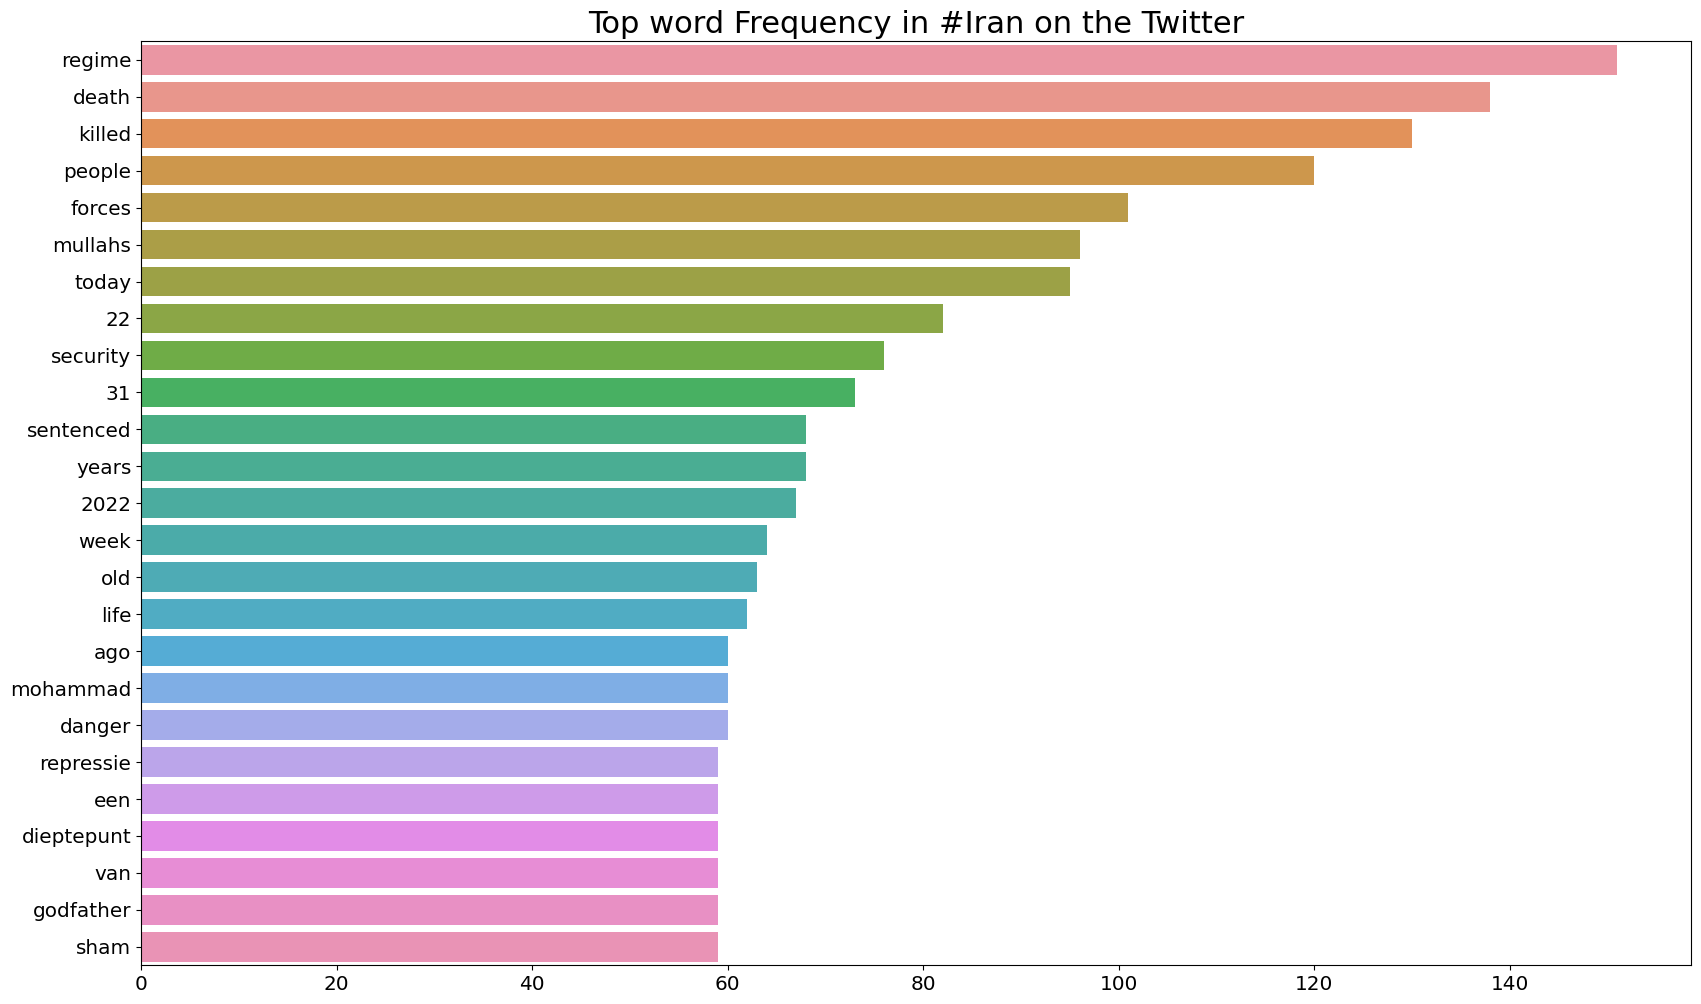

/var/folders/gy/scg9c9b176sck8t_0rgv5qj80000gn/T/ipykernel_44629/2001206058.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), fontsize='x-large')


<Figure size 640x480 with 0 Axes>

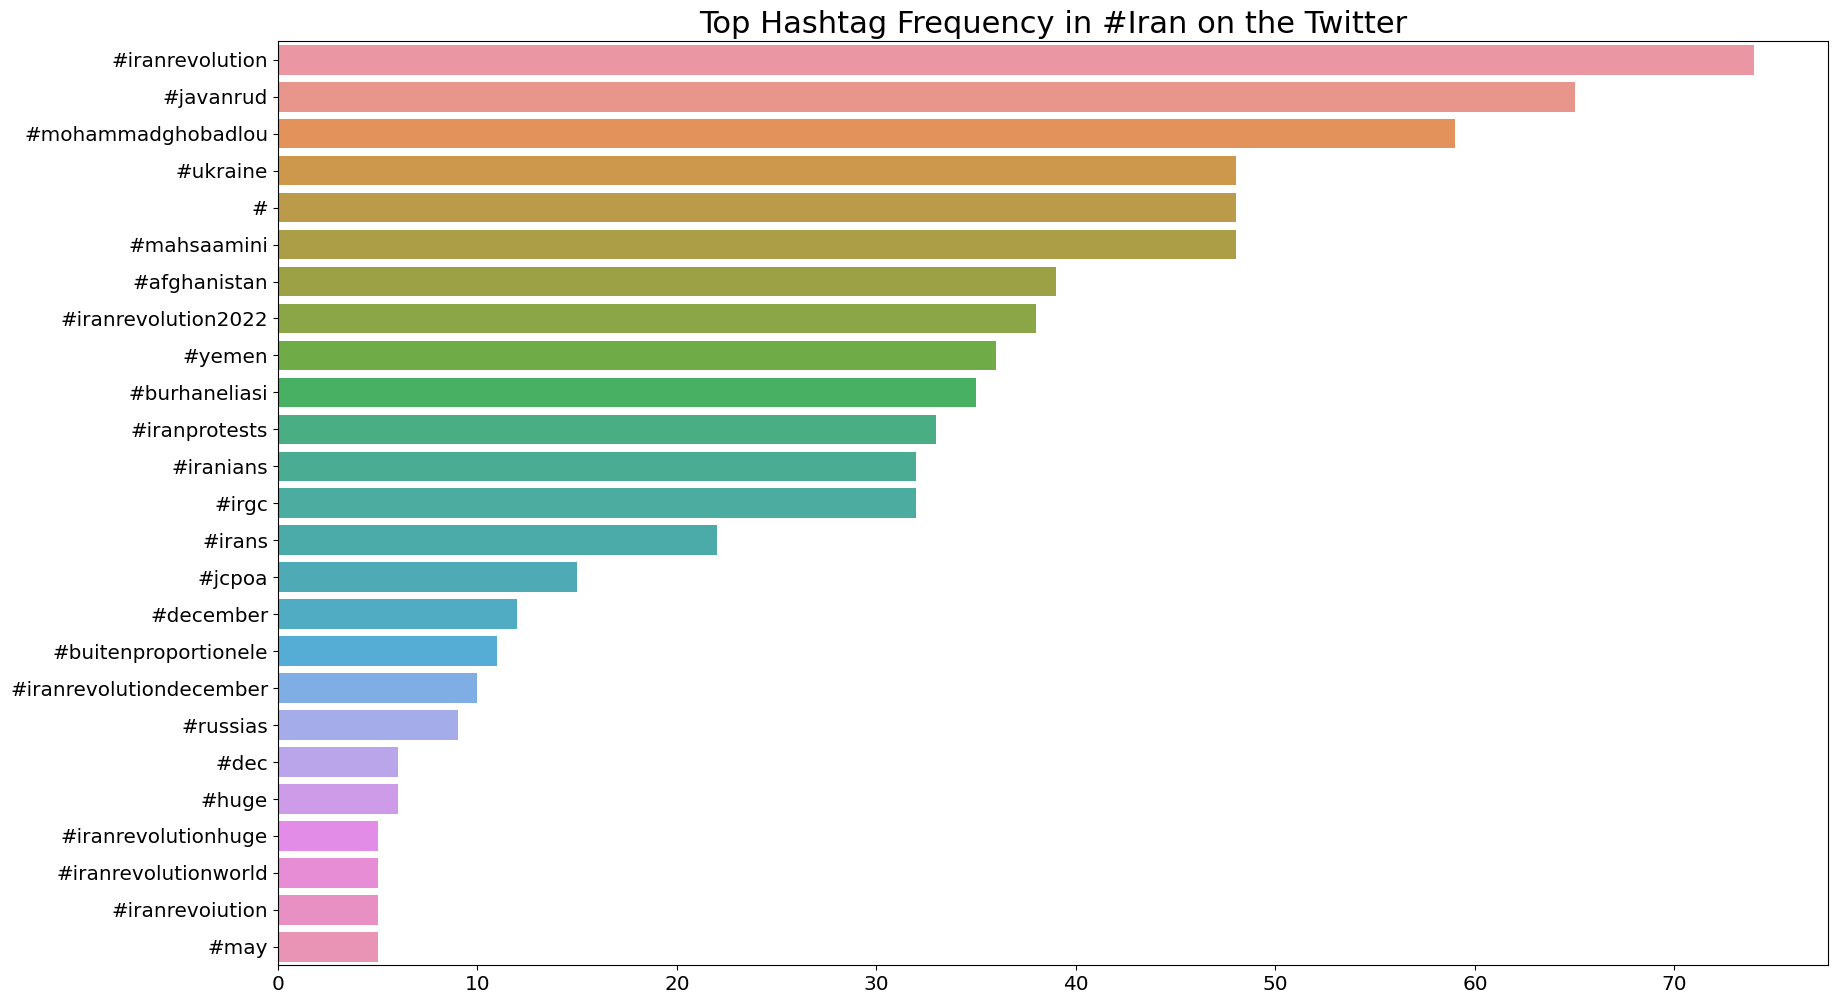

/var/folders/gy/scg9c9b176sck8t_0rgv5qj80000gn/T/ipykernel_44629/2001206058.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), fontsize='x-large')


<Figure size 640x480 with 0 Axes>

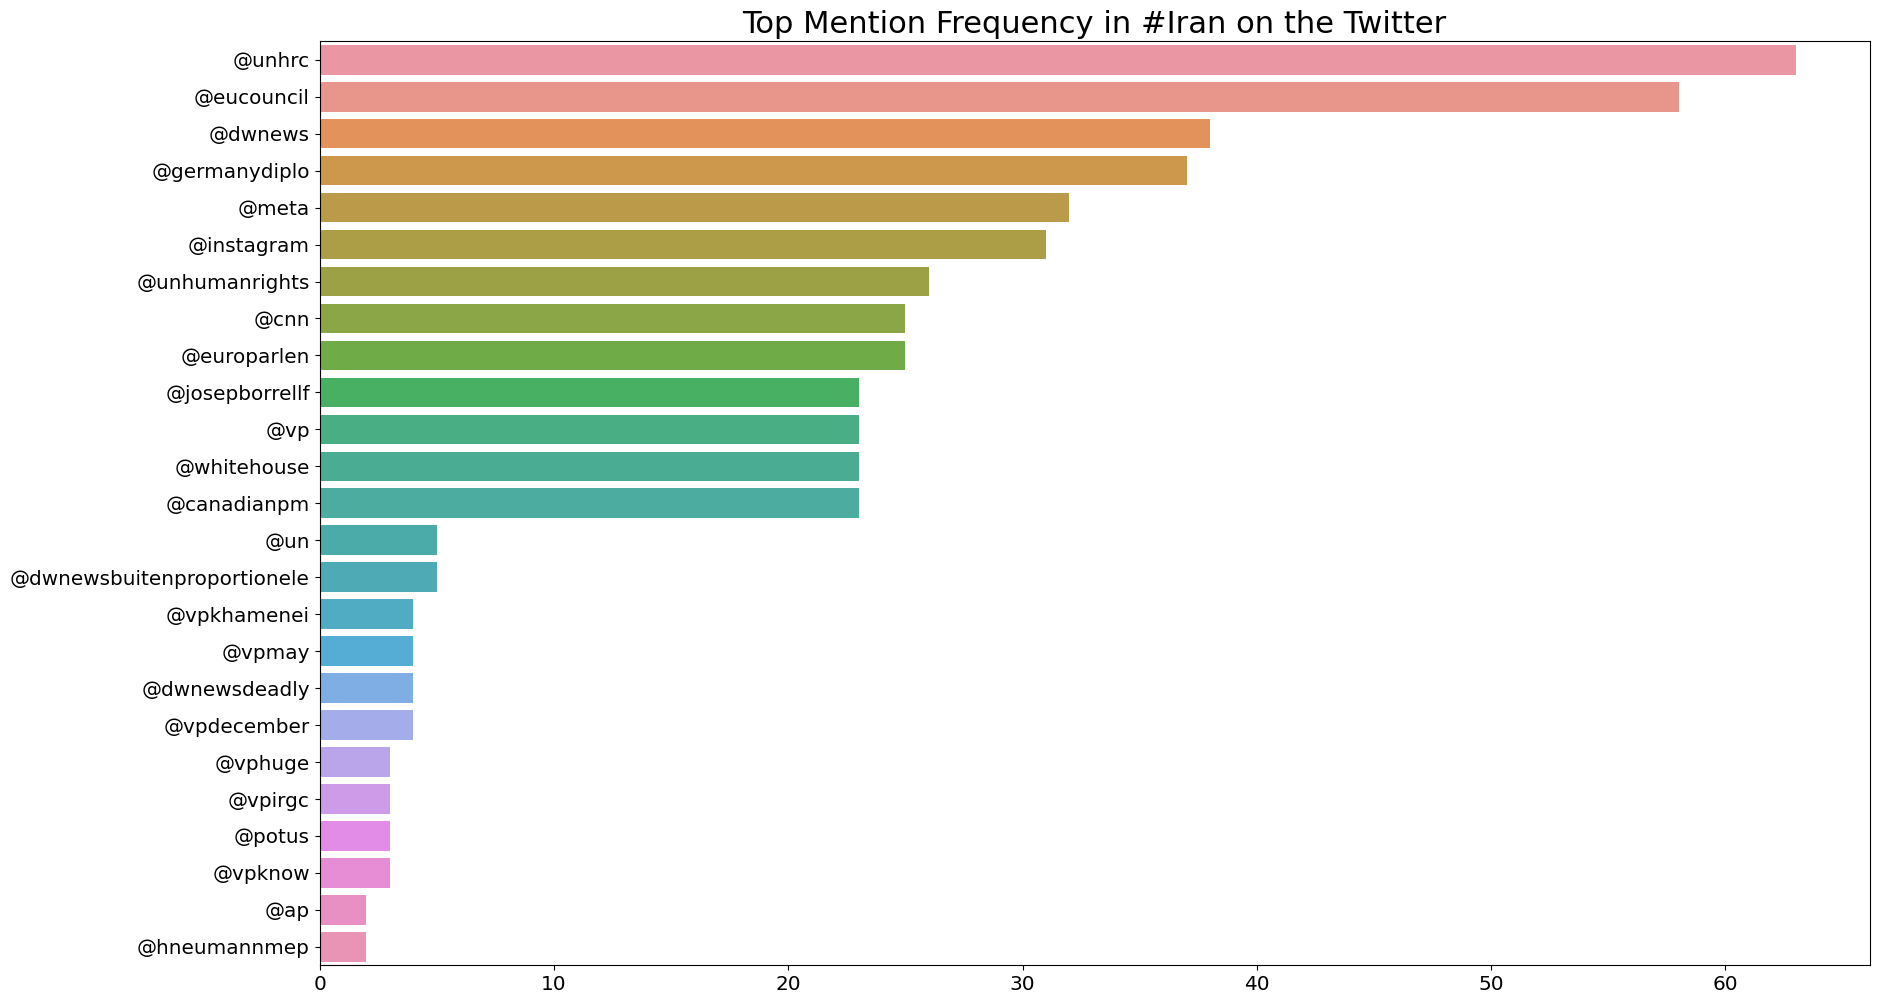

Yayyy The process is done! Your informaion is ready at #Iran_500Tweets_2022-12-31|18:18:13 Folder! 



<Figure size 640x480 with 0 Axes>

In [4]:
## Driver : 
while True: 
    hash_tag = str(input("Please tell us which #hastag do you want to see more information about ?(leave it free if you want to quit) "))
    if hash_tag == "" : break
    if hash_tag[0] != "#": print("Please enter a hashtag!")
    else:
        limit  =  input("Please tell us the number of tweets you us want to gather? (leave it free if you want to quit) ")
        if limit == "" : break
        try:
            limit = int(limit)
        except ValueError:
            print(f"Please enter a valid number!{limit} is not acceptable!")
        if limit < 0 :
            print("Limit could not be negative!")
        elif  0 <= limit < 20 :
            print("Thats too low! please enter at least 40 for the limit.")
        else :

            analyze_class = Tweet_analysis(hash_tag,limit)
            data = analyze_class.tweet_catchers()
            analyze_class.analysis(data)

            if data[data.columns[0]].count() < 40 : 
                print("Sorry! There is not enough tweets containing your hashtag to be analyzed! :( \n ")
                path = Path(f'{hash_tag}_{limit}Tweets_{time.strftime("%Y-%m-%d|%H:%M:%S")}')
                shutil.rmtree(path)
                    
            else :
                print(f'Yayyy The process is done! Your informaion is ready at {hash_tag}_{limit}Tweets_{time.strftime("%Y-%m-%d|%H:%M:%S")} Folder! \n')
            
            continuing = input("Shall we continue? (y/n)")
            if continuing.lower() in {"n", "no","nope","nah","nein"}: break

